In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()

sns.set_context("notebook", font_scale=1.5)

# Week 2 - Initial Planning

****
## Background
****

* Location: Kibutz Dafna
* Field area: 20137 m$^2$
* Soil: brown Rendzina
* Crop: Avocado

****
## Plant Demand
****

* From the IMS $ET_0$ was obtained.
* From  [University of California Division of Agriculture and Natural Resources](http://ucavo.ucr.edu/Irrigation/CropCoefficients.html) $K_c$ was obtained.
* According to $ET_c = K_c \times ET_0$, $ET_c$ was calculated.

In [2]:
ET0 = np.array([1.4, 2.0, 3.2, 4.2, 5.8, 6.8, 6.7, 6.2, 5.2, 3.5, 2.1, 1.3])
Kc = np.array([0.4, 0.5, 0.55, 0.55, 0.6, 0.65, 0.65, 0.65, 0.6, 0.55, 0.55, 0.5])
ETc = Kc * ET0

plant_demand = pd.DataFrame(np.c_[ET0, Kc, ETc], index=range(1,13),
                            columns=[r'$ET_0 $ [mm/day]',r'$K_c$',r'$ET_c $ [mm/day]'])
plant_demand.index.name = 'Month'
plant_demand

,$ET_0 $ [mm/day],$K_c$,$ET_c $ [mm/day]
Month,,,
1,1.4,0.40,0.560
2,2.0,0.50,1.000
3,3.2,0.55,1.760
4,4.2,0.55,2.310
5,5.8,0.60,3.480
6,6.8,0.65,4.420
7,6.7,0.65,4.355
8,6.2,0.65,4.030
9,5.2,0.60,3.120


Let's plot it:

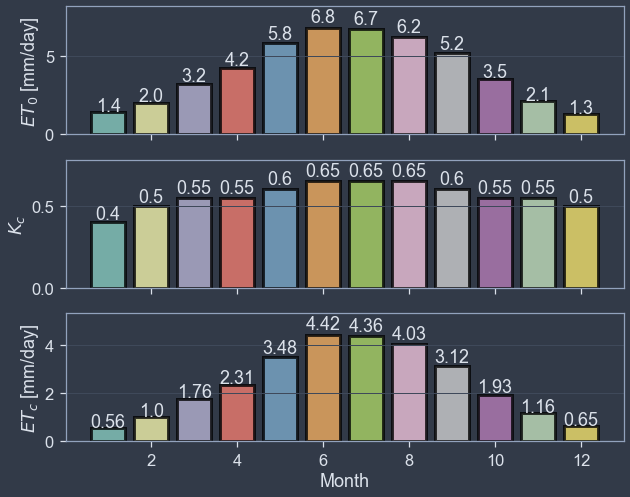

In [3]:
COLORS = plt.cm.Set3(np.linspace(0, 1, 12))  # 12 RGB instances for 12 months colors

def plot_monthly_series(axis, s):
    label = s.name
    color_indices = s.index - 1  # Indices to choose from colors - by month number
    axis.bar(s.index,
            s.values,
            color=COLORS[color_indices],
            edgecolor='black',
            lw=3,
             alpha=0.75)
    axis.grid(axis='x')
    axis.set_ylabel(label)
    axis.set_ylim(0,max(s.values)*1.2)
    # Plotting values
    for index, value in zip(s.index, s.values):
        if value  > 0:
            axis.text(index, value*1.05, str(round(value, 2)), ha='center')


fig = plt.figure(figsize=(10,8))
axes = [plt.subplot(3,1,i) for i in range(1,4)]

for i, col_name in zip(range(len(axes)), plant_demand):
    plot_monthly_series(axes[i], plant_demand[col_name])
    if i != len(axes)-1:
        axes[i].set_xticklabels([])
    else:
        axes[i].set_xlabel('Month')

#plt.savefig('plant_demand.png')

## Introducing Dynamic $K_c$ According to FAO

According to [FAO](https://www.fao.org/3/x0490e/x0490e0b.htm), the trends in $K_c$ during the growing period are represented in the crop coefficient curve which requires the following parameters:
* $K_c$ during the initial stage (Kc ini) = $\color{pink}{0.6}$
* $K_c$ during the mid-season stage (Kc mid)= $\color{pink}{0.85}$
* $K_c$ at the end of the late season stage (Kc end) = $\color{pink}{0.75}$

Now we need to construct the curve according to 4 stages:
* initial: according to the last graph it seems like from begining of 1 till the end of it.
* crop development: begining of 2 until end of 5
* mid-season - begining of 6 until the end of 9
* late season stage - begining of 9 until the end of 12

$\displaystyle K_c = 
\begin{cases}
  0.6  & 1 \le t \le 3  \\
  0.01923t+0.5423  & 3 < t < 16  \\
  0.85  & 16 \le t \le 27  \\
  -0.011 t + 1.15 & 27 < t \le 36  \\
\end{cases}$

Where $t = \text{10 days group of } \{1,2,3,...,36\}$

According to this information we construct a ten-day dynamic $K_c$

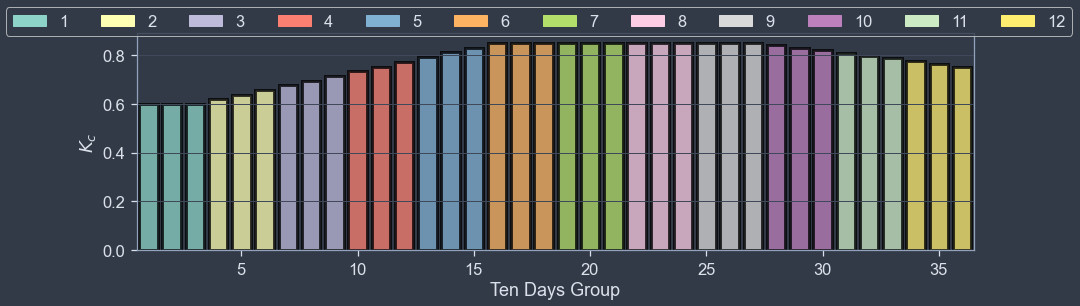

In [4]:
t = np.arange(1,37,1)
Kc = np.zeros(t.shape)
Kc = np.where(t > 0, 0.6 , Kc)
Kc = np.where(t > 3, 0.01923 * t + 0.5423, Kc)
Kc = np.where(t >= 16, 0.85 , Kc)
Kc = np.where(t > 27, -0.011 * t + 1.15 , Kc)

color_indices = np.array([[i,i,i] for i in range(0,12)]).flatten()

sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(15,4))
plt.bar(t, Kc, edgecolor='black', lw=3, color=COLORS[color_indices], alpha=0.75)
plt.grid(axis='x')
plt.xlabel('Ten Days Group')
plt.ylabel(r'$K_c$')
plt.xlim(0.5,36.5)

# Adding legend by creating patches without plotting them
handles = []
for m in range(1,13): # For every month
    patch = mpatches.Patch(color=COLORS[m-1], label=str(m))
    handles.append(patch)
fig.legend(handles=handles, ncol=12)

In [24]:
df = np.c_[(color_indices + 1).reshape(-1,1),np.array([[1,2,3] for _ in range(12)]).flatten().reshape(-1,1),Kc.reshape(-1,1)]
df = pd.DataFrame(df, columns=['Month','Tenth','Kc'])
df.to_excel('Water_Schedule.xlsx')




According to that, we construct our new monthly Kc and use this one to calculate ETc.

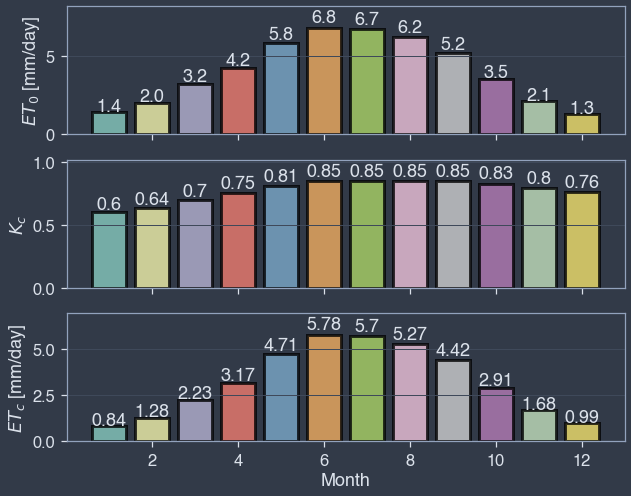

In [122]:
updated_Kc = []
for i in range(0,36,3):
    updated_Kc.append(np.mean(Kc[i:i+3]))

ETc = np.array(updated_Kc) * ET0
plant_demand[r'$K_c$'] = updated_Kc
plant_demand[r'$ET_c $ [mm/day]'] = ETc
    
fig = plt.figure(figsize=(10,8))
axes = [plt.subplot(3,1,i) for i in range(1,4)]

for i, col_name in zip(range(len(axes)), plant_demand):
    plot_monthly_series(axes[i], plant_demand[col_name])
    if i != len(axes)-1:
        axes[i].set_xticklabels([])
    else:
        axes[i].set_xlabel('Month')

****
## Effective Rain
****

Raw monthly rainfall data was downloaded from the [IMS website](https://ims.gov.il/he) using station number 310093 for monthes october 2011 until october 2021.

In [123]:
data = pd.read_csv('RainData/Dafna_monthly_rain_11-21.csv')
data

,station_num,Date,Rainfall,Rain code
0,310093,10-2011,1.4,0
1,310093,11-2011,121.2,0
2,310093,12-2011,33.2,0
3,310093,01-2012,257.2,0
4,310093,02-2012,160.3,0
...,...,...,...,...
99,310093,03-2021,36.2,0
100,310093,04-2021,16.0,0
101,310093,05-2021,0.0,0
102,310093,08-2021,0.0,0


The next cell deletes redundant columns, changing the columns name and seperate the year from the month:



In [124]:
data = data.iloc[:,1:3] # Deleting redundant columns
data.columns = ['Time', 'Rainfall [mm/month]']
data['Month'] = data['Time'].apply(lambda time: time.split('-')[0])
data['Year'] = data['Time'].apply(lambda time: time.split('-')[1])
data.drop(['Time'], inplace=True, axis=1) # Deleting redundant columns
data

,Rainfall [mm/month],Month,Year
0,1.4,10,2011
1,121.2,11,2011
2,33.2,12,2011
3,257.2,01,2012
4,160.3,02,2012
...,...,...,...
99,36.2,03,2021
100,16.0,04,2021
101,0.0,05,2021
102,0.0,08,2021


Calculating: 
* Mean monthly rainfall
* Std of the monthly rainfall
* 80% Dependable Rain according to: Mean - 0.84 $\times$ Std

In [125]:
month_values = np.array(data['Month'], dtype=int) # All data monthes values as integers
month_rain_mean = np.array([])
month_rain_std = np.array([])

for m in range(1,13): # Per each month calculating the mean and std
    i = np.where(month_values == m)
    mean = np.mean(data['Rainfall [mm/month]'].values[i])
    std = np.std(data['Rainfall [mm/month]'].values[i])
    month_rain_mean = np.append(month_rain_mean, mean)
    month_rain_std = np.append(month_rain_std, std)

# Getting rid of nan values where monthes are dry
month_rain_mean = np.where(np.isnan(month_rain_mean), 0, month_rain_mean)
month_rain_std = np.where(np.isnan(month_rain_std), 0, month_rain_std)

# calculating 80% dependable rainfall
dep_rain_80 = month_rain_mean - 0.84 * month_rain_std

rain_data = pd.DataFrame(np.c_[month_rain_mean, month_rain_std, dep_rain_80],
                         index=range(1,13),
                         columns=['Monthly Rain Mean [mm]',
                                  'Monthly Rain Std [mm]',
                                  '80% Dependable Rain [mm]'])
rain_data.index.name = 'Month'
rain_data

/Users/yuvalbayer/opt/anaconda3/envs/Env_1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yuvalbayer/opt/anaconda3/envs/Env_1/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yuvalbayer/opt/anaconda3/envs/Env_1/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yuvalbayer/opt/anaconda3/envs/Env_1/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/yuvalbayer/opt/anaconda3/envs/Env_1/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype

,Monthly Rain Mean [mm],Monthly Rain Std [mm],80% Dependable Rain [mm]
Month,,,
1,179.130000,74.122615,116.867003
2,92.070000,49.357270,50.609893
3,57.750000,42.919232,21.697845
4,33.480000,24.784261,12.661221
5,13.410000,16.514142,-0.461880
6,5.500000,9.198478,-2.226722
7,0.000000,0.000000,0.000000
8,0.122222,0.257241,-0.093860
9,0.160000,0.237487,-0.039489


Let's plot 80% Dependable Rain:

Text(0.5, 0, 'Month')

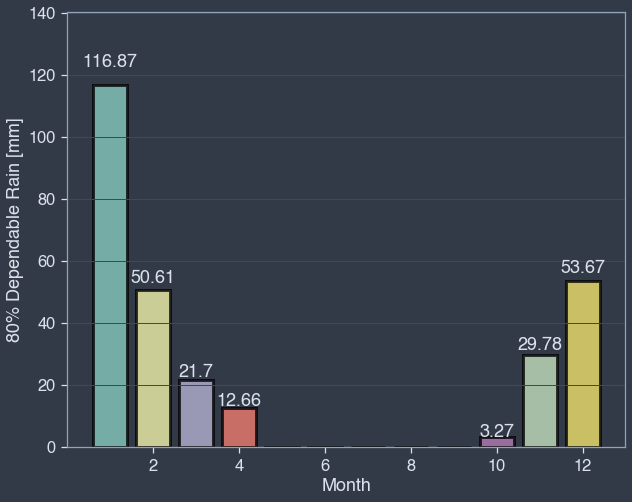

In [126]:
sns.set_context("notebook", font_scale=1.5)
fig, axis = plt.subplots(figsize=(10,8))
plot_monthly_series(axis, rain_data['80% Dependable Rain [mm]'])
axis.set_xlabel('Month')
#plt.savefig('dependable_rain.png')

And the next code is for visualizing all of the raw data of monthly rain (probably it's better to use other IDE for visualizing):

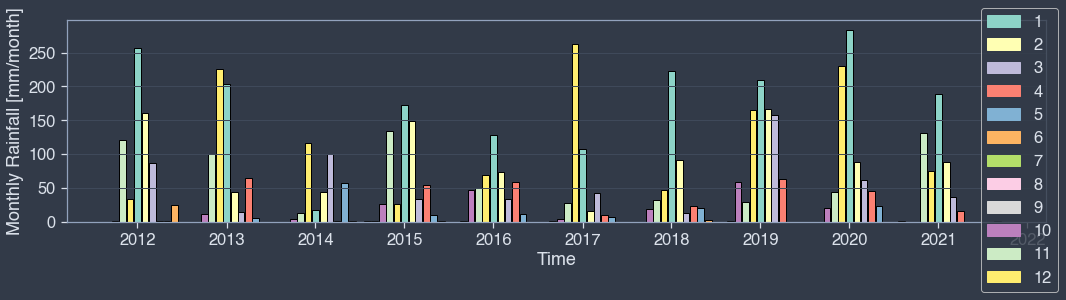

In [127]:
# Creating the Timestamp column
data['Timestamp'] = data[['Year','Month']].apply(lambda x: pd.Timestamp(x[0]+'-'+x[1]+'-01T12'), axis=1)
data.drop(['Month', 'Year'], inplace=True, axis=1) # Deleting redundant columns

sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(15,4))

bar_width = pd.Timedelta(days=28)
color_indices = data['Timestamp'].apply(lambda x: x.month) - 1 # Indices to choose from colors

plt.bar(data['Timestamp'],
        data['Rainfall [mm/month]'],
        width=bar_width,
        color=COLORS[color_indices],
        edgecolor='black',
        lw=1)
plt.grid(axis='x')

# Adding legend by creating patches without plotting them
handles = []
for m in range(1,13): # For every month
    patch = mpatches.Patch(color=COLORS[m-1], label=str(m))
    handles.append(patch)
fig.legend(handles=handles)

plt.xlabel('Time')
plt.ylabel('Monthly Rainfall [mm/month]')
plt.tight_layout()
#plt.savefig('rain_data.png')

****
## Maximum Irrigation Demand
****

According to:

$\displaystyle IR_n = ET_c - (Pe + Ge + Wb) + LR_{mm}$

$\displaystyle IR_b = \frac{IR_n}{E}$

In the maximum state, we use values of:
* Maximum $ET_c=5.78$ mm/day
* Corresponding effective rainfall $Pe=0$ mm/day. Due to 80% Dependable Rain = 0.
* No salts washing
* $Ge, Wb \approx 0$ mm/day
* Assuming $E\approx90 \%$ according to the fact that we use localized irrigation system.

In [128]:
IRn = max(ETc) 
IRb = IRn / 0.9
IRb

6.422222222222222

$IR_b = 6.42$ mm/day.

****
## $d_x$ Calculation
****

In soil testing course, a relative similar soil to our was measured (Randazina from Ravid). Some of the measurements are:

* Field Capacity: 37.6 $\frac{g_\text{water}}{g_\text{soil}}$
* Permanent Wilting Point: 10.2 $\frac{g_\text{water}}{g_\text{soil}}$
* Bulk Density: $D_b$ = 1.15

So in order to get the volumetric water content we need to use:

$\displaystyle \theta_v =D_b \times \frac{\theta_w}{D_\text{water}} $

In [129]:
Db = 1.15
FC_w = 0.376 # [-] Field Capacity - weight fraction
PWP_w = 0.102 # [-] Permanent Wilting Point - weight fraction

FC = Db * FC_w # [-] Field Capacity - volumetric fraction
PWP = Db * PWP_w # [-] Permanent Wilting Point - volumetric fraction

(FC, PWP)

(0.43239999999999995, 0.11729999999999999)

In [130]:
TAM = (FC - PWP) * 1e3 # from [m/m] to [mm/m]
TAM 

315.0999999999999

* Field Capacity: **$\color{pink}{\text{FC = 432 mm/m}}$**
* Permanent Wilting Point: **$\color{pink}{\text{PWP = 117 mm/m}}$**

So:
* Total Available Moisture: **$\color{pink}{\text{TAM = 315 mm/m}}$**.
* Accoding to [Bender and Faber](https://ucanr.edu/sites/alternativefruits/files/166631.pdf), MAD = 30-50%. However, it's recommended to use 50% for heavy soils. So **$\color{pink}{\text{MAD = 50%}}$**.
* According to ([Salgado and Cautin, 2008](https://www.sciencedirect.com/science/article/pii/S0378377408000516?casa_token=uqF60wXjMw8AAAAA:olQdXg7JNnKy8DoC9ARB5q-cBPuzWPwXzG93-os0vRD2fnoMY0g79aNHI64DTB88NeMyySr1)), Z=0.3-0.6 m. So **$\color{pink}{\text{Z = 0.5 m}}$**.

In adidition, we need to consdier $P_w$ according to:

$\displaystyle P_w = 
\begin{cases}
  100 \frac{N_pS_ew}{S_pS_r} & \text{if} &  S_e < 0.8w  \\
  100 \frac{0.8N_pw^2}{S_pS_r} & \text{if} & S_e \ge 0.8w
\end{cases}$

According to the [FAO](https://www.fao.org/3/ai598e/ai598e.pdf), in the absence of locally available data on the wetted patterns of one emmiter, we can use the area wetted by one emitter as depending on soil type according to:

| Soil Type | Area wetted by one emitter (m$^2$) |
|-----------|------------------------------------|
| Sandy     | 0.5-2                              |
| Loam      | 2-6                                |
| Clay      | 6-15                               |

We consider our soil as clay  A$_\text{wet}$ = 6 - 15 m$^2$. The diameter of the area is:

D$=\sqrt{4\times\text{A}_\text{wet}/\pi}=2.76 - 4.71$ m. We will take value of 3 m $\rightarrow$ **$\color{pink}{w = 3 \text{m}}$**

According to locally available data:
* The usually space between emitters: $\color{pink}{S_e = 0.4 \text{m}}$.
* The space between trees and rows is $\color{pink}{S_p=3\text{m}}$ and $\color{pink}{S_r=6\text{m}}$ respectively.
* The number of emitters per tree depends on the development stage. According to ([Salgado and Cautin, 2008](https://www.sciencedirect.com/science/article/pii/S0378377408000516?casa_token=uqF60wXjMw8AAAAA:olQdXg7JNnKy8DoC9ARB5q-cBPuzWPwXzG93-os0vRD2fnoMY0g79aNHI64DTB88NeMyySr1)), roots distribution is pretty wide, we'll take $\color{pink}{N_p=5\text{m}}$ as an average.

In [131]:
w = 3
Se = 0.4
Sp = 3
Sr = 6
Np = 5

Pw = 100 * (Np * Se * w) / (Sp * Sr)
Pw

33.333333333333336

So we use 33.33% as the value of the wet area in the field.

According to:

$\displaystyle d_x = \text{MAD}\times\text{TAM}\times\text{Z}\times\frac{P_w}{100}$

In [132]:
MAD = 0.5 # [-]
Z = 0.5 # [m]
dx = MAD * TAM * Z * Pw / 100
dx # [mm]

26.258333333333326

$\color{pink}{d_x=\text{26.26 mm}}$.

We can calculate now the flow per irrigation by:

$\displaystyle Q = d_x \times A$

In [133]:
A = 20137 # [m^2]
Q = dx * 1e-3 * A # [m^3/irr]
Q

528.7640583333332

$\color{pink}{Q = 528.76\text{ m}^3/\text{irrigation}}$

The irrigation frequency is calculated by:

$\displaystyle f_x = \frac{d_x}{IR_b}$

In [134]:
fx = dx / IRb
fx

4.088667820069204

$f_x \approx 4 \text{ days}$

So we going to reduce 3 days to get a frequency of $\color{pink}{f_x \approx 2 \text{ to } 1 \text{ days}}$

****
## Map
****

We used the [GovMap]([https://www.govmap.gov.il/) website with the [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) in order to get the coordinate data of our plot which is according to this plot:

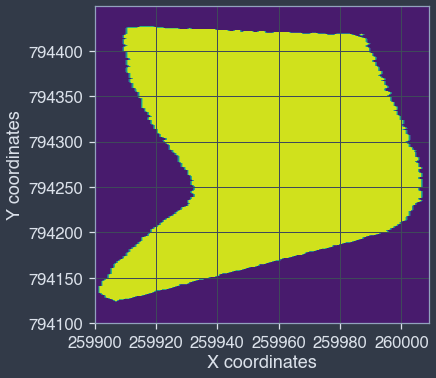

In [135]:
plt.figure()
x = np.load('CoordinatesData/x.npy')
y = np.load('CoordinatesData/y.npy')
z = np.load('CoordinatesData/z.npy')
plt.contourf(x, y, z)
plt.ticklabel_format(useOffset=False)
plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')
plt.tight_layout()

out_of_bound_i = np.argwhere(z == 0)

Then from the contour lines of altitude in the original map we sample points of 160, 165, 170 and 175 to interpolate all of the coordinate values

(259775.0, 260150.0)

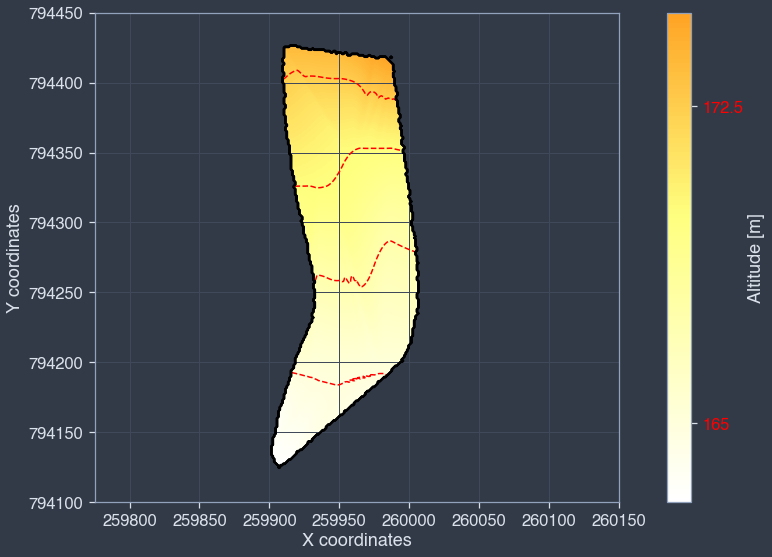

In [136]:
from scipy.interpolate import griddata

valued_z = []
valued_xy = []
for contour_value in [160,165,170,175]:
    data = pd.read_csv('AltitudeData/{}contour.csv'.format(contour_value))
    for instance in data.values:
        valued_xy.append(instance)
        valued_z.append(contour_value)
valued_z = np.array(valued_z)
valued_xy = np.array(valued_xy)

fig, axis = plt.subplots(figsize=(15,8))
xy = np.c_[x.flatten(),y.flatten()]
altitude = griddata(valued_xy, valued_z, xy, 'cubic').reshape(z.shape)
altitude[out_of_bound_i[:,0],out_of_bound_i[:,1]] = np.nan
cs_contourf = plt.contourf(x,y,altitude,1000, cmap='afmhot_r',vmax=190)
clabel = plt.contour(x,y,altitude,[165,167.5,170,172.5],
                     colors='red',
                     linestyles='dashed')
plt.ticklabel_format(useOffset=False)

cbar = fig.colorbar(cs_contourf,ticks=[165,172.5])
cbar.ax.set_yticklabels([165,172.5],color='red')
cbar.set_label('Altitude [m]')

plt.contour(x, y, z,colors='black', linewidths =1.5)
plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')
plt.tight_layout()
axis.set_aspect('equal', 'box')
plt.ylim(794100,794450)
plt.xlim(259775,260150)
#plt.savefig('map.png')

# NOTE

For the next notebooks, we save this plotting code as a function in the file functions.py